In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2


## Neuron Ablation

Neuron count 2: Mean=50.00%, SD=0.00% from 5 samples
Neuron count 3: Mean=78.02%, SD=0.57% from 5 samples
Neuron count 4: Mean=72.11%, SD=1.56% from 5 samples
Neuron count 5: Mean=79.10%, SD=1.31% from 5 samples
Neuron count 6: Mean=69.01%, SD=1.82% from 5 samples
Neuron count 7: Mean=74.39%, SD=2.23% from 5 samples
Neuron count 8: Mean=74.86%, SD=2.15% from 5 samples
Neuron count 9: Mean=69.19%, SD=1.25% from 5 samples
Neuron count 10: Mean=73.63%, SD=2.06% from 5 samples


/var/folders/g4/b0tp89t57dbbzgsx2sl8tcq00000gn/T/ipykernel_15100/1052541162.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


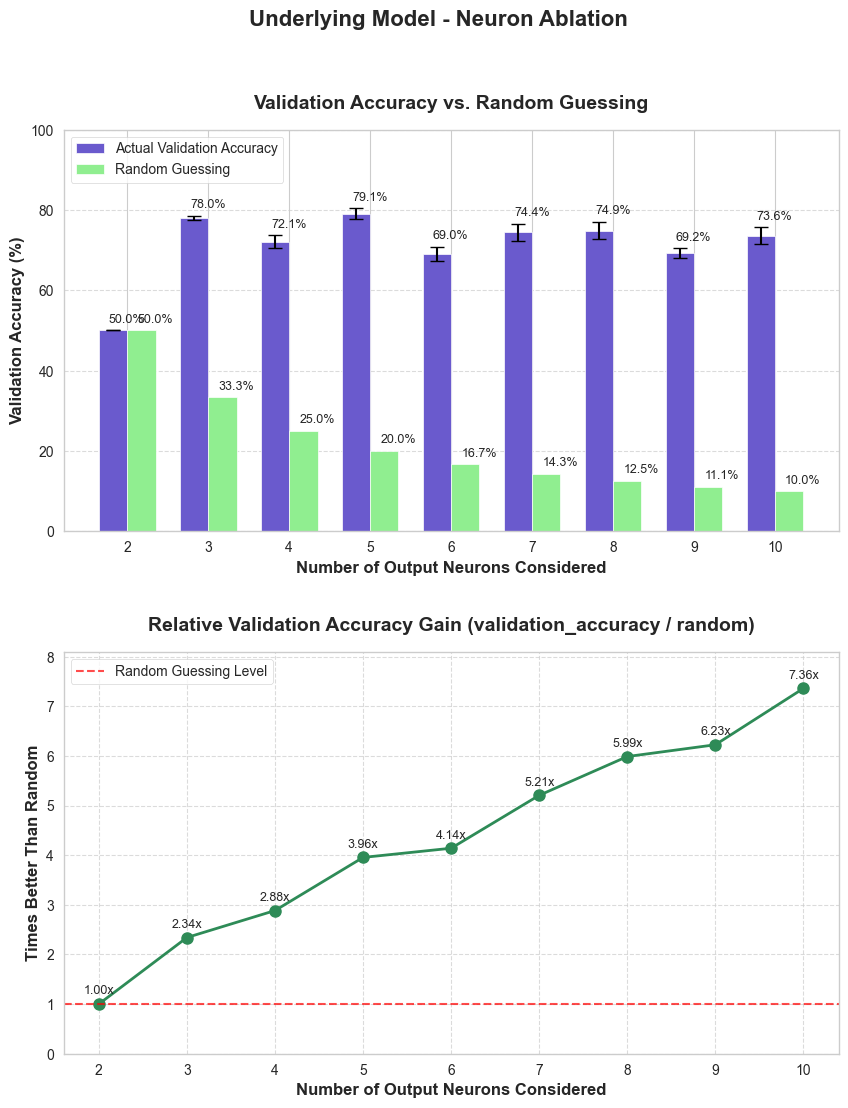

In [21]:


# Set style for better-looking plots
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Load data
df = pd.read_csv('../data/mnist_ablation_results.csv')

# Group data by neuron count
neurons = list(range(2, 11))
results = []

for n in neurons:
    # Filter data for this neuron count
    neuron_data = df[df['num_neurons'] == n]
    
    # Calculate mean and standard deviation of validation accuracy
    acc_mean = neuron_data['valid_acc'].mean()
    acc_std = neuron_data['valid_acc'].std(ddof=1)  # Using sample standard deviation
    
    # Print information for verification
    print(f"Neuron count {n}: Mean={acc_mean*100:.2f}%, SD={acc_std*100:.2f}% from {len(neuron_data)} samples")
    
    # Calculate random guessing validation accuracy
    random_guess = 1/n
    
    # Calculate gains over random guessing
    additive_gain = acc_mean - random_guess
    relative_gain = acc_mean / random_guess
    
    results.append({
        'neurons': n,
        'validation_accuracy': acc_mean * 100,  # Convert to percentage
        'std_dev': acc_std * 100,  # Convert to percentage
        'random_guess': random_guess * 100,  # Convert to percentage
        'additive_gain': additive_gain * 100,  # How many percentage points above random
        'relative_gain': relative_gain  # How many times better than random
    })

# Convert to DataFrame and sort by neuron count
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('neurons')

# Create a nice figure with 2 subplots in a grid
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Plot 1: Validation Accuracy vs Random Guessing
ax1 = plt.subplot(gs[0])

# Set width of bars
barWidth = 0.35
r1 = np.arange(len(neurons))
r2 = [x + barWidth for x in r1]

# Create grouped bars
ax1.bar(r1, results_df['validation_accuracy'], width=barWidth, color='#6A5ACD', 
       yerr=results_df['std_dev'], capsize=5, label='Actual Validation Accuracy')
ax1.bar(r2, results_df['random_guess'], width=barWidth, color='#90EE90', label='Random Guessing')

# Add labels and title
ax1.set_xlabel('Number of Output Neurons Considered', fontweight='bold')
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax1.set_title('Validation Accuracy vs. Random Guessing', fontweight='bold', pad=15)
ax1.set_xticks([r + barWidth/2 for r in range(len(neurons))])
ax1.set_xticklabels(neurons)
ax1.set_ylim(0, 100)

# Add gridlines
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add a legend
ax1.legend(loc='upper left')

# Add value labels above bars
for i, v in enumerate(results_df['validation_accuracy']):
    ax1.text(i - 0.05, v + 2 + results_df['std_dev'].iloc[i], f"{v:.1f}%", fontsize=9)
for i, v in enumerate(results_df['random_guess']):
    ax1.text(i + barWidth - 0.05, v + 2, f"{v:.1f}%", fontsize=9)

# Plot 2: Relative Gain
ax2 = plt.subplot(gs[1])
ax2.plot(neurons, results_df['relative_gain'], 'o-', color='#2E8B57', linewidth=2, markersize=8)

# Add horizontal line at y=1 (random guessing performance)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Random Guessing Level')

# Add labels and title
ax2.set_xlabel('Number of Output Neurons Considered', fontweight='bold')
ax2.set_ylabel('Times Better Than Random', fontweight='bold')
ax2.set_title('Relative Validation Accuracy Gain (validation_accuracy / random)', fontweight='bold', pad=15)
ax2.set_xticks(neurons)
ax2.set_ylim(0, results_df['relative_gain'].max() * 1.1)

# Add gridlines
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels above points
for i, v in enumerate(results_df['relative_gain']):
    ax2.text(neurons[i], v + 0.2, f"{v:.2f}x", ha='center', fontsize=9)

# Add a legend
ax2.legend(loc='upper left')

# Add overall title
plt.suptitle('Underlying Model - Neuron Ablation', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and save
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('../images/fig4.png', dpi=300, bbox_inches='tight')
plt.show()

### Input-layer task

In [40]:
df = pd.read_csv('../data/inputpixel_dropout_valid_mse.csv')
df.columns = ['step', 'mean_mse', 'max_mse', 'min_mse']

#### compute variance of validation set

In [36]:
from datasets import FirstLayerDataModule
data_module = FirstLayerDataModule(
        '../underlying/saved_models/fully_connected_dropout-mnist-hidden_dim_[50,50]',
        positional_encoding_type='dist_center',
        batch_size=64,
        num_workers=0,
    )

In [ ]:
import torch
import numpy as np # Often useful for final analysis/printing

# Assuming data_module is your initialized FirstLayerDataModule instance
# data_module = FirstLayerDataModule(...)

# --- Setup and Access Validation Data ---
# data_module.prepare_data() # If needed
data_module.setup('validate') # Sets up the validation dataset

# Get the validation dataloader
val_loader = data_module.val_dataloader()

# --- Collect all validation labels ---
all_val_labels = []
print("Iterating through validation data...")
with torch.no_grad(): # Disable gradient calculation
    for batch in val_loader:
        # We need to know the structure of your batch.
        # Assuming the second element is the label tensor 'y'.
        # Common structures: (inputs, targets)
        # Adjust batch[1] if your structure is different.
        if isinstance(batch, (list, tuple)) and len(batch) > 1:
            labels = batch[1]
        else:
            # Handle cases where the loader might yield something else
            # or only inputs. You might need to adjust this.
            print("Warning: Could not extract labels from batch. Skipping batch.")
            print(f"Batch type: {type(batch)}, Batch content (first element type): {type(batch[0]) if isinstance(batch, (list, tuple)) and len(batch)>0 else 'N/A'}")
            continue # Skip this batch if labels aren't found as expected

        # Ensure labels are numerical (float or int).
        # Variance/std dev on non-numerical data is not meaningful.
        if not torch.is_floating_point(labels) and not torch.is_complex(labels):
             # If labels are integers (like class indices), variance might not be
             # what you want. Converting to float for calculation anyway.
             labels = labels.float()
             # print("Warning: Labels appear to be integers. Converting to float for variance calculation.")


        # Move data to CPU if it's on GPU
        all_val_labels.append(labels.cpu())

print("Concatenating labels...")
# Concatenate all batches into a single tensor
if not all_val_labels:
    print("No labels collected from validation loader. Cannot compute statistics.")
else:
    val_labels_tensor = torch.cat(all_val_labels, dim=0)
    print(f"Total validation labels collected: {val_labels_tensor.shape[0]}")
    if val_labels_tensor.ndim > 1 and val_labels_tensor.shape[1] > 1:
        print(f"Label dimension: {val_labels_tensor.shape[1:]} (multi-dimensional labels found)")
    elif val_labels_tensor.ndim == 0:
         print(f"Labels are scalars (0-dimensional).")
    else:
         print(f"Label dimension: Scalar (1D tensor of labels)")


    # --- Compute Statistics ---
    # Ensure the tensor is treated as float for calculations
    val_labels_tensor = val_labels_tensor.float()

    # Compute variance and standard deviation
    # Use unbiased=True (ddof=1) for sample variance/std dev if needed
    label_variance = torch.var(val_labels_tensor, unbiased=False)
    label_std_dev = torch.std(val_labels_tensor, unbiased=False)

    print(f"\nValidation Set Label Variance: {label_variance.item():.4f}")
    print(f"Validation Set Label Standard Deviation: {label_std_dev.item():.4f}")



Iterating through validation data...
Concatenating labels...
Total validation labels collected: 156800
Label dimension: Scalar (1D tensor of labels)

Validation Set Label Variance: 0.0435
Validation Set Label Standard Deviation: 0.2086


In [59]:
# --- Calculate R2 Score per Step ---
# Avoid division by zero or near-zero variance
label_variance_val = label_variance.item()
df['mean_r2'] = 1.0 - (df['mean_mse'] / label_variance_val)
df['min_r2'] = 1.0 - (df['min_mse'] / label_variance_val)
df['max_r2'] = 1.0 - (df['max_mse'] / label_variance_val)



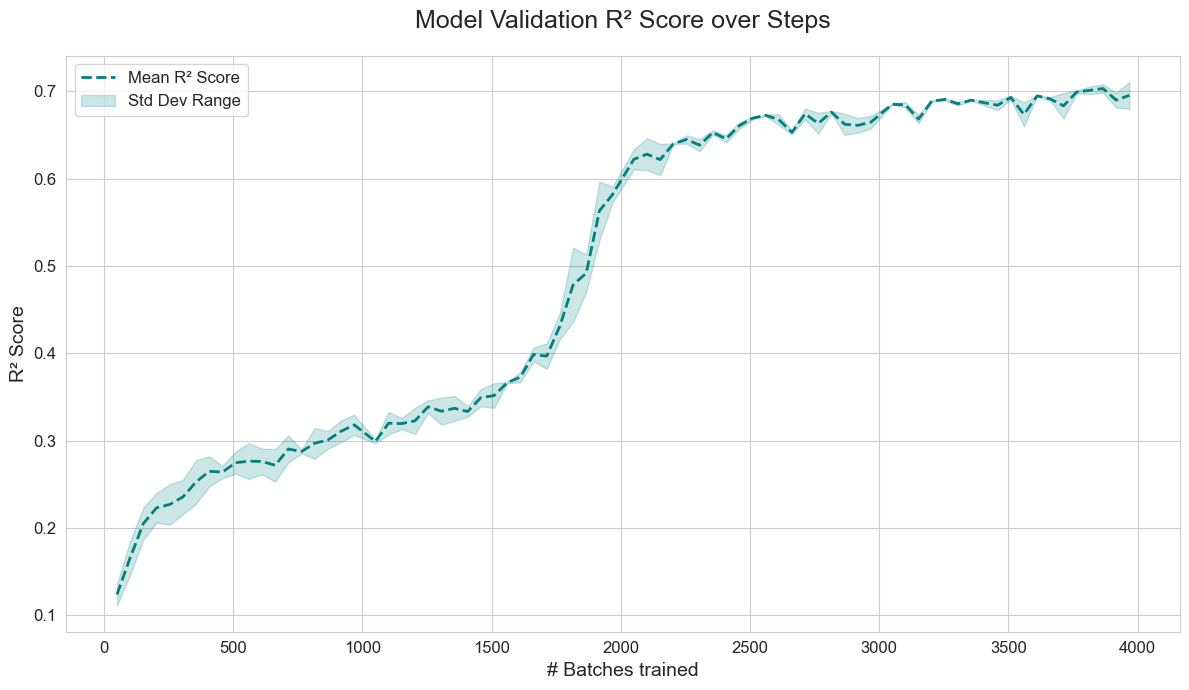

In [65]:

import seaborn as sns
sns.set_style("whitegrid")

# Define font sizes
title_fontsize = 18
label_fontsize = 14
tick_fontsize = 12
legend_fontsize = 12

# Define plot color
plot_color = 'teal' # A nice blue-green color

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot R2 Score (Primary Y-axis)
ax1.set_xlabel('# Batches trained', fontsize=label_fontsize)
# Set Y-label without specific color, using default black/axis color
ax1.set_ylabel('R² Score', fontsize=label_fontsize)

# Plot the mean line
line1 = ax1.plot(df['step'], df['r2_score'],
                 label='Mean R² Score',
                 color=plot_color,
                 linestyle='--',
                 linewidth=2) # Make line slightly thicker

# Add confidence interval (STD) band
fill1 = ax1.fill_between(df['step'], df['min_r2'], df['max_r2'],
                         color=plot_color,
                         alpha=0.2,        # Keep alpha light for the fill
                         label='Std Dev Range')

# Set tick parameters - apply larger size, default color
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Keep grid lines (seaborn style takes care of this, but doesn't hurt)
# ax1.grid(True, axis='y', linestyle='--', alpha=0.7) # You can customize if needed

# Set Title with larger font size
plt.title('Model Validation R² Score over Steps', fontsize=title_fontsize, pad=20) # Add padding

# Add Legend with larger font size
# 'loc=best' tries to find the least obstructive location
ax1.legend(loc='best', fontsize=legend_fontsize)

# Adjust layout to prevent labels overlapping
fig.tight_layout()

# Show the plot
plt.show()